# Area 51
Test Code Chunks here before going into Production.

## Simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os  # For Saving to Folder

from matplotlib import gridspec

In [9]:
class Simulator(object):
    """Simulator Class for HMMs. 
    This is the main Class, all specific Simulators can inherit from it
    and overwrite functions. 
    Contains Parameters"""
    l = 1000 # Nr of the Observations
    k = 20 # Nr of Reference Haplotypes
    lats = [] # The l latent States [l]
    pure_stat = [] # The pure, unnoisy States [l]
    ob_stat = []  # The observed State [l]
    ref_states = [] # Ref. Array of k Reference States to Copy from. [kxl]
    
    ref_sim = 0 # Simulator object for References
    
     
    def __init__(self, refsim=0):
        """refsim: Which Reference Simulator to use. If 0, set to Binomial"""
        self.stats = np.ones(self.l) # Initialize the states to -1 (i.e. Unset)
        
        if refsim == 0:
            refsim = BinomSimRefNoLD()
            
        self.set_ref_sim(sim=refsim)   # Set the Reference Simulator
        self.ref_sim.set_params(k=self.k, l=self.l)
        
    def set_ref_sim(self, sim):
        """Set the Reference Simulator to sim"""
        self.ref_sim = sim
        
    def simulate_latent(self):
        """Simulate all l latent States"""
        raise NotImplementedError("Implement the Simlator!!")
        
    def error_model(self):
        """Apply error model to all l latent States"""
        self.stats = np.array(self.pure_stats) # The Latent State is the Same as the true State
        
    def simulate_full(self):
        """Return all Statistics"""
        sim.simulate_ref()
        sim.simulate_latent() # Simulate the Latent States
        hap1 = sim.copyHaplo()
        hap2 = sim.copyHaplo()
        self.pure_stat = np.array([hap1, hap2]) # Combine the 2 Haplotypes
        sim.apply_error()
        print("Full Simulation Finished.")
    
    def simulate_ref(self):
        """Generate the reference Data Set"""
        
        if self.ref_sim == 0:      # If not set, reset it
            sim = BinomSimRefNoLD()
            print("Setting Ref Simulator")
            self.set_ref_sim(sim)
            
        self.ref_states = self.ref_sim.simulate_refs()
        print("Finished Simulation of Ref")
        
    def apply_error(self):
        """Applies the Error Model"""
        self.ob_stat = self.pure_stat  # Default: Don't have any Error.
    
    def save_data(self, folder="../Simulated/Test0/"):
        """Save the simulated Data to a Directory"""
        
        # Check if Folder there. If not make it
        if not os.path.exists(folder):
            os.makedirs(folder)
        
        np.savetxt(folder + "refs.csv", self.ref_states, delimiter = ",",  fmt='%i') # Save Reference Haplotypes
        np.savetxt(folder + "hap.csv", sim.ob_stat, delimiter = ",",  fmt='%i')      # Save Genotype Vector
        np.savetxt(folder + "lat.csv", self.lats, delimiter = ",",  fmt='%i')        # Save Hidden Path 
        print(f"Successfully saved to: {folder}")     
        
    def copyHaplo(self):
        """Copy from Haplotypes Refs via latent states"""
        lat, refs = self.lats, self.ref_states # For easier Notation
        
        # Do HW draws:
        p_mean = np.mean(refs, axis=0)
        y = np.random.binomial(1, p_mean) # Do Hardy Weinberg Draw
        
        subs = lat>0             # Boolean Array where to sub in Ref Data
        sub_inds = lat[subs] - 1   # Indices to Sub In (shift by one because of convention)
        y[subs] = refs[sub_inds, subs]
        return y # Set the observed Status
           
#####################################################
#####################################################
#####################################################

class BinomSim(Simulator):
    """Bimomial Simulator.
    Assume equally spaced SNPs.
    Copying: 0: From HW state. 1,...,n from Reference Data Set [n]"""
    spacing = []    # Spacing between SNPs [in Morgan]
    
    roh_in = 0.002      # The rate of jumping to another Haplotype
    roh_out = 0.01     # The rate of jumping out
    roh_jump = 0.05    # The rate of jumping within ROH     
    
    def set_cons_spacing(s=0.1):
        """Set the spacing of SNPs"""
        self.spacing = np.ones(self.l) * s  # Set the constant Spacing
    
    def set_params(self):
        """Set the parameters"""
        raise NotImplementedError("Implement this.")  
        
    def first_state(self):
        """Generate the first latent state"""
        return 0
        
    def sim_copying(self):
        """Simulate the Vector with States to copy from"""
        print(self.l)
        states = -np.ones(self.l, dtype="int")  # Initialize all states to invalid values 
        
        i = 0   # The current Position
        state = self.first_state() # Generate first step
        
        # Iterate along line until done:
        while i < self.l:  
            if state == 0:
                t, n_state = self.jump_no_roh()
                
            elif state >0:
                t, n_state = self.jump_roh()
                
            else:
                raise RuntimeError("WTF DUDE")
                
            j = i + t
            states[i:j] = state # Make it that State    
            i, state = j, n_state # Go to next position
        return states
    
    def jump_no_roh(self):
        """Generate length and next state not in ROH"""
        m = 1 / self.roh_in
        t = np.random.exponential(scale=m)
        t = np.ceil(t).astype("int")   # Round Up
        n_state = np.random.randint(self.k) + 1 # The next state
        return t, n_state
    
    def jump_roh(self):
        """Generate length and next state in ROH"""
        m = 1 / (self.roh_out + self.roh_jump) # The overall rate for any jump
        t = np.random.exponential(scale=m) # Where next event happens
        t = np.ceil(t).astype("int")   # Round Up
        
        if np.random.random() <  self.roh_jump * m:  # Chance of staying in
            n_state = np.random.randint(self.k) + 1 # The next state. Could perhaps reuse prob.
            
        else:
            n_state = 0 # Jump back to the origin
        return t, n_state
                
    def simulate_latent(self):
        """Simulate l latent States"""
        ### Do a copying vector: Each state is from whom you copy
        # Do all randomness:
        self.lats = self.sim_copying()  # Get all latent states

    def draw_from_latent(self):
        """Draw from all latent States."""
        raise NotImplementedError("Implement This!!!")
    
#####################################################
#####################################################
###### Reference Simulator

class SimRef(object):
    """Class for Simulating the Reference Strings"""
    refs = []
    haps = []
    
    def simulate_refs(self):
        """Simulate and return Reference Strings"""
        raise NotImplementedError("Implement this!")   
        
    def set_params(self):
        """Set parameters"""
        raise NotImplementedError("Implement this!")
    
    def plot_ld_r2(self, haps=[], l=200, fs=18):
        """Plot R2 across pw. Distances of SNPs"""
        if len(haps)==0:
            haps=self.haps
    
        c = np.corrcoef(haps[:,:l], rowvar=False) # Do Correlation within 200 SNPs

        k = int(np.ceil(l/2))

        r2vec = np.zeros(k)


        for i in range(k): ### Get all diagonals
            d = np.diag(c, k=i)
            r2 = np.nanmean(d**2) # To get r**2 Value (with NANs because sometimes no correlation)
            r2vec[i] = r2

        xarr = np.arange(k) + 1 # Make Vector of all pairwise Distances

        plt.figure()
        plt.plot(xarr, r2vec, "bo")
        plt.xlabel("Pw. Distance [Loci]", fontsize=fs)
        plt.ylabel(r"Correlation $r^2$", fontsize=fs)
        plt.axhline(y=0, linewidth=2)
        plt.show()
        
class BinomSimRefNoLD(SimRef):
    """Simulate References under a Binomial Model.
    For the moment: Do not do any LD Structure"""
    h = 2     # Nr of different Haplotypes
    k = 100   # Nr of overall Haplotypes
    l = 1000  # Length of the Haplotypes
    p = 0.5   # Mean Allele Frequency
    
    #def set_params(self, h=5, k=100, l=1000, p=0.5):
    #    """Set Parameters for reference"""
    #    self.h=h
    #    self.k=k
    #    self.l=l
    #    self.p=p
    #    print("k set")
    #    print(self.k)
        
    def set_params(self, **kwargs):
        """Set Attributes with keyworded Arguments"""
        for key, value in kwargs.items():
            setattr(self, key, value)
        
    def simulate_refs(self):
        """Simulate References under a Binomial Model"""
        h, k, l = self.h, self.k, self.l  # For better Readability
        
        ### Simulate effective Haplotypes 
        e_haps = np.random.binomial(1, 0.5, size=(h, l))
        haps = np.zeros((k, l), dtype="int") # Set to zero
        
        for i in range(h):
            haps[i::h] = e_haps[i,:] # Set every ith entry

        self.haps = haps
        return haps

## Mini Area 51

Finished Simulation of Ref
1000
Full Simulation Finished.
Successfully saved to: ../Simulated/Test0/


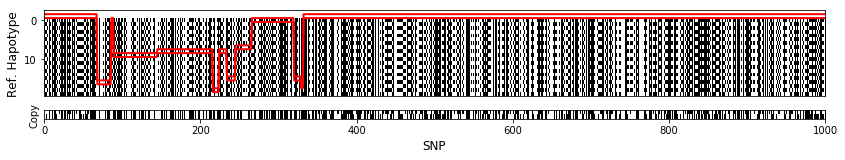

In [7]:
### Plot Binomial Sampling
sim = BinomSim()
sim.ref_sim.set_params(h=2)
sim.simulate_full()
sim.save_data(folder="../Simulated/Test0/")

### Attach the copied Haplotype
#plot_hap = np.array([sim.ob_stat for _ in range(1)])

fs = 12

plt.figure(figsize=(14,2))
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1])
gs.update(hspace=0.3) # set the spacing between axes. 

ax = plt.subplot(gs[0]) # The left subplot
ax1 = plt.subplot(gs[1]) # The middle one

ax.imshow(sim.ref_states, cmap='Greys',  aspect='auto')
ax.plot(sim.lats-1.5, linewidth=2, color="red") # Plot upper Boarder
ax.plot(sim.lats-0.5, linewidth=2, color="red") # Plot lower boarder

ax.set_ylabel("Ref. Hapotype",fontsize=fs)
#ax.axhline(-.3)
ax.set_xticks([])

# Do the Reference SNP
ax1.imshow(sim.ob_stat, cmap='Greys',  aspect='auto')
ax1.set_xlabel("SNP", fontsize=fs)
ax1.set_yticks([])
ax1.set_ylabel("Copy")

plt.savefig("../figures_test/haplotypes.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
sim.ref_sim.plot_ld_r2()

In [ ]:
%%time
sim = BinomSim()
sim.simulate_latent() # Simulate the Latent States

### Do the Plot
fs = 14
plt.figure(figsize=(12,4))
plt.plot(sim.lats, linewidth=2, color="maroon") # For Plotting them
plt.ylabel("State", fontsize=fs)
plt.xlabel("SNP", fontsize=fs)
plt.ylim([-0.9,20.5])
plt.show()

In [ ]:
np.shape(sim.ref_states)

# Multivariate Normal
Simulate multivariate Normally Distributed loci

In [126]:
nr_loci = 1000
nr_ref = 20
l = np.zeros(nr_loci)  # The latent States around which one varies

def logit(x):
    """Define a Logit Function"""
    y = 1 / ( 1 + np.exp(-x) )
    return y

In [127]:
### Prep the Covariance Matrix.
positions = np.arange(nr_loci)
pw_dist = np.abs(positions[:,None]-positions)  # Calculate all pairwise D

cov = 100.0 * np.exp(-pw_dist/ 200) 
latent = np.random.multivariate_normal(l, cov, size = nr_ref).T

f = logit(latent)      # Get the Probabilities
assert(np.min(f)>=0.0)
assert(np.max(f)<=1.0)

genos = np.random.binomial(n=1, p=f)


# Produce Binomial Genotypes:
est_cov = np.cov(genos)
est_cor = np.corrcoef(genos)

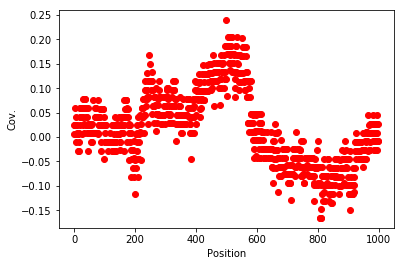

In [128]:
plt.figure()
plt.plot(est_cov[:,500], "ro")
plt.xlabel("Position")
plt.ylabel("Cov.")
plt.show()

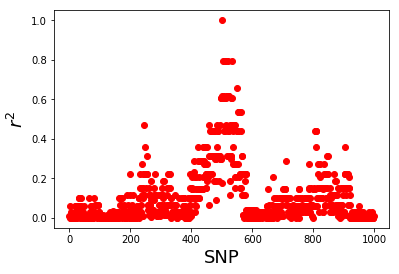

In [129]:
fs = 18

plt.figure()
plt.plot(est_cor[:,500]**2, "ro")
plt.xlabel("SNP", fontsize=fs)
plt.ylabel(r"$r^2$", fontsize=fs)
plt.show()

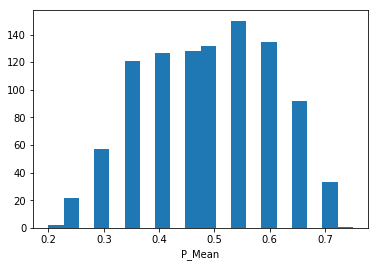

In [130]:
# Do the Site Frequency Spectrum:
p_means = np.mean(genos, axis=1)

plt.figure()
plt.hist(p_means, bins=20)
plt.xlabel("P_Mean")
plt.show()

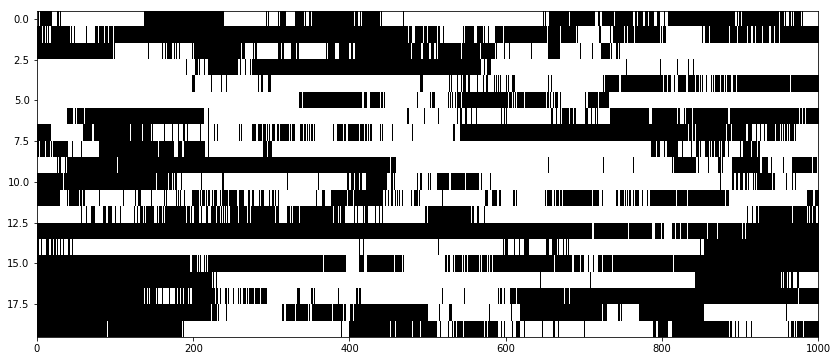

In [132]:
plt.figure(figsize=(14,6))
plt.imshow(genos.T, cmap='Greys',  aspect='auto')
plt.show()

# Area 51 to test code

In [31]:
plt.figure()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [135]:
np.arange(1,5)

array([1, 2, 3, 4])